Tabii! Aşağıda **uçtan uca, tek dosya** halinde çalışan bir **LSTM ile zaman serisi tahmini** örneği var.

* Veri: Sentetik (sinüs + trend + gürültü)
* Hedef: “Geçmiş `lookback` gün” → “yarınki değer”
* İçerir: ölçekleme, pencereleme, train/val/test ayrımı, LSTM modeli, `EarlyStopping`, `ReduceLROnPlateau`, eğitim grafikleri, test MSE/MAE ve örnek tahmin çizimi.

> Python 3.8+ ve `tensorflow>=2.9`, `numpy`, `pandas`, `matplotlib`, `scikit-learn` yeterli.

```python

Şekiller -> X_train: (810, 30, 1) y_train: (810, 1) X_val: (150, 30, 1) y_val: (150, 1) X_test: (150, 30, 1) y_test: (150, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
 

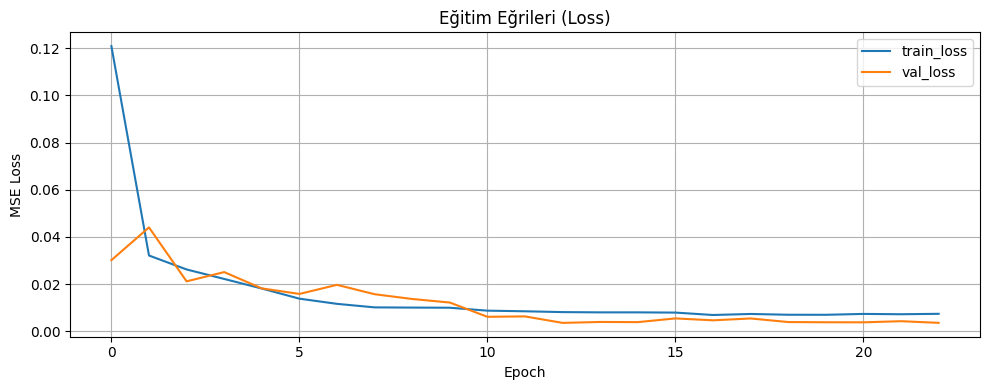

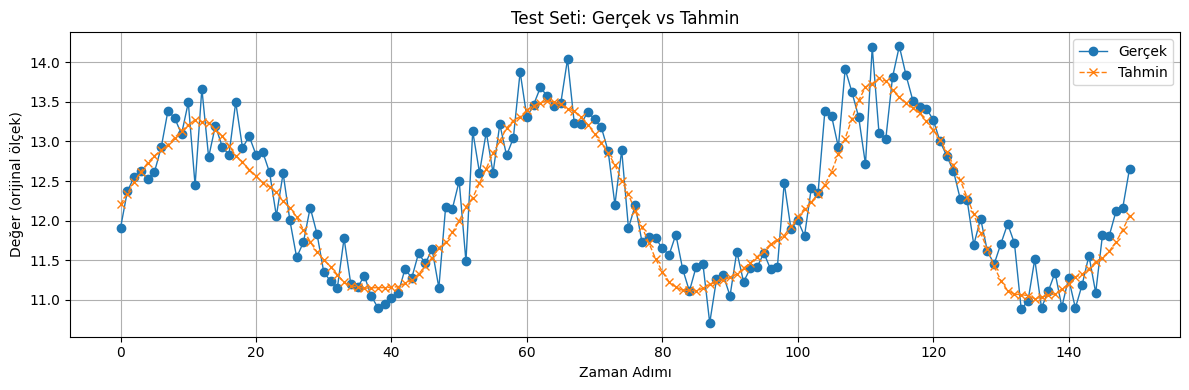

ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [1]:
# lstm_time_series_example.py
# ---------------------------
# Uçtan uca LSTM zaman serisi tahmini (regresyon) örneği.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models

# --- 0) Tekrarlanabilirlik
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- 1) Sentetik veri üret (sinüs + trend + gürültü)
def generate_series(n_points=1200, noise_std=0.3):
    t = np.arange(n_points)
    trend = 0.002 * t                          # hafif artan trend
    season = 1.2 * np.sin(2*np.pi*t/50)       # periyodik bileşen
    noise = np.random.normal(0, noise_std, n_points)
    series = 10 + trend + season + noise
    return pd.DataFrame({"value": series}, index=pd.RangeIndex(n_points, name="t"))

df = generate_series()

# --- 2) Train/Val/Test böl
#   (ör: ilk %70 train, sonraki %15 val, son %15 test)
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

# --- 3) Ölçekleme (yalnızca train ile fit, diğerlerine transform)
scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
df_val_scaled   = pd.DataFrame(scaler.transform(df_val),   columns=df_val.columns,   index=df_val.index)
df_test_scaled  = pd.DataFrame(scaler.transform(df_test),  columns=df_test.columns,  index=df_test.index)

# --- 4) Pencereleme yardımcı fonksiyonu
def make_windows(values: np.ndarray, lookback: int = 30, horizon: int = 1):
    """
    values: (N, 1) ölçeklenmiş seri
    lookback: geçmiş kaç zaman adımı girdi olacak
    horizon: ileri kaç adım tahmin (burada 1 = yarın)
    Dönüş: X:(num_samples, lookback, 1), y:(num_samples,)
    """
    X, y = [], []
    for i in range(len(values) - lookback - horizon + 1):
        X.append(values[i:i+lookback])
        y.append(values[i+lookback:i+lookback+horizon])
    X = np.array(X)           # (samples, lookback, 1)
    y = np.array(y).reshape(-1, horizon)  # (samples, horizon)
    return X, y

LOOKBACK = 30
HORIZON  = 1

X_train, y_train = make_windows(df_train_scaled[["value"]].values, LOOKBACK, HORIZON)
X_val,   y_val   = make_windows(df_val_scaled[["value"]].values,   LOOKBACK, HORIZON)
X_test,  y_test  = make_windows(df_test_scaled[["value"]].values,  LOOKBACK, HORIZON)

print("Şekiller ->",
      "X_train:", X_train.shape,
      "y_train:", y_train.shape,
      "X_val:", X_val.shape,
      "y_val:", y_val.shape,
      "X_test:", X_test.shape,
      "y_test:", y_test.shape)

# --- 5) Model (LSTM + Dropout + Dense)
def build_model(lookback: int, n_features: int = 1, horizon: int = 1) -> tf.keras.Model:
    inputs = layers.Input(shape=(lookback, n_features))
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(horizon)(x)   # regresyon çıktısı
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

model = build_model(LOOKBACK, n_features=1, horizon=HORIZON)
model.summary()

# --- 6) Callbacks
ckpt_path = "best_lstm.keras"
cbs = [
    callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1)
]

# --- 7) Eğitim
BATCH_SIZE = 64
EPOCHS = 100

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=cbs
)

# --- 8) En iyi modeli yükle (checkpoint)
if os.path.exists(ckpt_path):
    model = tf.keras.models.load_model(ckpt_path)

# --- 9) Test değerlendirme
pred_test_scaled = model.predict(X_test)
# Orijinal ölçeğe dön (inverse_transform): dikkat horizon=1 olduğu için düzleştirip geri saracağız
def inverse_scale(scaled_values):
    # scaled_values shape: (N, 1)
    tmp = np.zeros((len(scaled_values), 1))
    tmp[:, 0] = scaled_values[:, 0]
    inv = scaler.inverse_transform(tmp)[:, 0]
    return inv

y_test_inv  = inverse_scale(y_test)
pred_test_inv = inverse_scale(pred_test_scaled)

mse = mean_squared_error(y_test_inv, pred_test_inv)
mae = mean_absolute_error(y_test_inv, pred_test_inv)
print(f"TEST -> MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} | MAE: {mae:.4f}")

# --- 10) Grafikler
# Eğitim eğrileri
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Eğitim Eğrileri (Loss)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Test seti tahmin/gerçek karşılaştırma
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label="Gerçek", marker="o", linewidth=1)
plt.plot(pred_test_inv, label="Tahmin", linestyle="--", marker="x", linewidth=1)
plt.title("Test Seti: Gerçek vs Tahmin")
plt.xlabel("Zaman Adımı")
plt.ylabel("Değer (orijinal ölçek)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 11) Tek adım örnek tahmin (son test penceresi)
example_idx = -1
example_in  = X_test[example_idx:example_idx+1]          # (1, lookback, 1)
example_pred_scaled = model.predict(example_in)
example_pred = inverse_scale(example_pred_scaled.reshape(-1,1))[0]

print(f"Örnek tek adım tahmin (son pencere) -> Tahmin: {example_pred:.3f}")

In [ ]:
```

### Notlar (mühendislik bakışı)

* **Giriş şekli:** `(batch, lookback, features)`; burada `features=1` (tek değişkenli seri).
* **Kayıplar/Metri̇k:** Regresyon için `MSE` (loss) + `MAE` (metric).
* **Callbacks:** `EarlyStopping` aşırı öğrenmeyi önler; `ReduceLROnPlateau` öğrenme oranını otomatik düşürür; `ModelCheckpoint` en iyi ağı kaydeder.
* **GPU kullanımı:** TensorFlow varsa otomatik tespit eder (NVIDIA CUDA). Yüksek batch size genelde GPU’da daha verimlidir.
* **Mini-batch:** `batch_size=64` varsayılan iyi bir başlangıç; veri/gpu durumuna göre 32–256 arası deneyebilirsin.

İstersen aynı iskeleti **GRU** ile de gösterebilirim (sadece `layers.LSTM` → `layers.GRU`), ya da **çok değişkenli zaman serisi** (örn. 3 sensör) için `features>1` sürümünü de yazayım. Hangi varyantı istersin?